## Analysis of staypoints locations with trackintel library.

Required pip libraries: 
- azure-ai-ml
- azure-identity
- pandas
- trackintel
- folium
- geopandas

The dataset consists of ca. 43 Million rows, only Lisbon area from February to March.

Fixing libraries:
- Install pandas with pip
- pip install -U scikit-learn
- scipy delete pip installation and install with conda scipy
- pip uninstall threadpoolctl
- pip install threadpoolctl
- pip install requests
- pip install urllib3

### 1. Authenticate with Azure ML client and import libraries. 

In [1]:
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml.entities import Data
from azure.ai.ml.constants import AssetTypes
import pandas as pd
from azure.ai.ml.entities import Environment
import trackintel as ti
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import folium

# authenticate
#credential = DefaultAzureCredential()
ml_client = MLClient.from_config(credential=DefaultAzureCredential(), path="config.json")

Found the config file in: config.json


### Load all saved pickle files

In [ ]:
_loc = pd.read_pickle("locations.pkl")
locations = pd.read_pickle("locations_df.pkl")
_sp = pd.read_pickle("staypoints.pkl")
sp = pd.read_pickle("spytns.pkl")

In [3]:
_pfs = pd.read_pickle("positionfixes.pkl")  
tpls = pd.read_pickle("triplegs.pkl")  

In [4]:
modal_split = pd.read_pickle("modal_split_per_user.pkl")

In [8]:
home_work_freq = pd.read_pickle("homw_work_freq.pkl")
home_work_osna = pd.read_pickle("homw_work_osna.pkl")

### Load all pickle files into GeoPandas from Trackintel


In [ ]:
staypoints = ti.io.read_staypoints_gpd(sp, started_at='started_at', finished_at='finished_at', tz='Europe/Lisbon')
pfx = ti.io.read_positionfixes_gpd(_sp, tracked_at="tracked_at", user_id='user_id', geom_col='geometry', tz='Europe/Lisbon')
_loc_df = ti.io.read_locations_gpd(_loc, user_id='user_id', center='geometry')


TypeError: read_triplegs_gpd() got an unexpected keyword argument 'center'

In [18]:
tpls_df = ti.io.read_triplegs_gpd(tpls, user_id='user_id',  geom_col='geom', tz='Europe/Lisbon')
home_work_freq_df = ti.io.read_locations_gpd(home_work_freq, user_id='user_id', center='geometry')
home_work_osna = ti.io.read_locations_gpd(home_work_osna, user_id='user_id', center='geometry')

### 2. Read parquet files from Blob storage connected to Azure ML
The dataset should be first added into Datasets in ML studio

In [3]:
data_asset = ml_client.data.get(name="lisboa_feb_march", version="1")

# Get the actual path (usually a URI to blob or datalake)
data_path = data_asset.path

In [4]:
df = pd.read_parquet(data_path)  

In [27]:
df.head(10)

,unique_id,hour_band_id,a_imsi,wrgc_a_msisdn,call_id,cal_year_id,cal_month_id,cal_day_id,a_bts_cgi,a_lac_id,...,cellradius_4g,cellradius_5g,azimuth,added LAC,r,azi_min1,azi_max1,event_date,count,distrito
0,08GcaR5hWj9xkKRuUeE07UHAv+zEUjOq/i1VZWPtcPPM=_...,17.0,08GcaR5hWj9xkKRuUeE07UHAv+zEUjOq/i1VZWPtcPPM=,35196795XXXX,194872947,2024,202402,20240209,2664202510,2510,...,None,None,145,None,154,75,200,2024-02-09,168,LISBOA
1,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,23.0,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=,35191751XXXX,292474939,2024,202402,20240209,288607000027,27,...,None,None,90,None,127,30,150,2024-02-09,294,LISBOA
2,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,40.0,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=,35193400XXXX,2097145568,2024,202402,20240227,297281400028,28,...,None,None,340,None,64,0,0,2024-02-27,125,LISBOA
3,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,36.0,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=,35196156XXXX,693344727,2024,202402,20240210,291295000015,15,...,None,None,180,None,158,120,240,2024-02-10,184,LISBOA
4,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,32.0,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=,35191759XXXX,-1206945904,2024,202402,20240205,293496600002,2,...,None,None,180,None,241,90,270,2024-02-05,191,LISBOA
5,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,30.0,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=,35193112XXXX,1192815708,2024,202402,20240212,7945793500165,165,...,30,None,240,None,376,175,370,2024-02-12,243,LISBOA
6,0t8hcKWr1ERUUFBxNHPJ1bhrMoFfzTPAqXo2qyV9r2Bc=_...,32.0,0t8hcKWr1ERUUFBxNHPJ1bhrMoFfzTPAqXo2qyV9r2Bc=,35193565XXXX,2088251318,2024,202402,20240202,432102010,2010,...,None,None,20,None,246,-50,90,2024-02-02,457,LISBOA
7,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,27.0,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=,35191840XXXX,690661410,2024,202402,20240210,293624700012,12,...,None,None,280,None,718,-140,175,2024-02-10,369,LISBOA
8,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,33.0,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=,35191820XXXX,997990825,2024,202402,20240224,7963461500165,165,...,15,None,300,None,1296,255,390,2024-02-24,553,LISBOA
9,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,34.0,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=,35193933XXXX,390908433,2024,202402,20240209,1584632000,32000,...,None,None,350,None,601,280,400,2024-02-09,155,LISBOA


### 3. Select only columns that are needed for analysis 
- unique_id: user identifier
- latitutude_cell: lat location of antenna
- longitude_cell: lon location of antenna
- time_id: timestamp of event

In [28]:
pdf = df[["unique_id", "latitude_cell", "longitude_cell", "time_id"]]

### 4. Converting dataframe into geopandas df and the locations points into geometry

In [29]:
pdf["geometry"] = gpd.points_from_xy(pdf["longitude_cell"], pdf["latitude_cell"])

# assuming your df has 'longitude' and 'latitude' columns
#pdf["geometry"] = pdf.apply(lambda row: Point(row["longitude_cell"], row["latitude_cell"]), axis=1)
gdf = gpd.GeoDataFrame(pdf, geometry="geometry", crs="EPSG:4326")

/tmp/ipykernel_4019/1928441608.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pdf["geometry"] = gpd.points_from_xy(pdf["longitude_cell"], pdf["latitude_cell"])


In [81]:
import trackintel

In [30]:
gdf.head(10)

,unique_id,latitude_cell,longitude_cell,time_id,geometry
0,08GcaR5hWj9xkKRuUeE07UHAv+zEUjOq/i1VZWPtcPPM=_...,38.897488,-9.038759,2024-02-09 08:58:26.0,POINT (-9.03876 38.89749)
1,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.702778,-9.230803,2024-02-09 11:56:21.0,POINT (-9.2308 38.70278)
2,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.707329,-9.147932,2024-02-27 20:13:20.0,POINT (-9.14793 38.70733)
3,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.759209,-9.263709,2024-02-10 18:15:28.0,POINT (-9.26371 38.75921)
4,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.757893,-9.112000,2024-02-05 16:29:36.0,POINT (-9.112 38.75789)
5,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,39.038513,-8.932646,2024-02-12 15:19:04.0,POINT (-8.93265 39.03851)
6,0t8hcKWr1ERUUFBxNHPJ1bhrMoFfzTPAqXo2qyV9r2Bc=_...,38.707035,-9.304289,2024-02-02 16:24:14.0,POINT (-9.30429 38.70704)
7,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.822918,-9.289584,2024-02-10 13:40:28.0,POINT (-9.28958 38.82292)
8,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.906227,-9.252336,2024-02-24 16:42:24.0,POINT (-9.25234 38.90623)
9,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.883354,-9.195980,2024-02-09 17:28:13.0,POINT (-9.19598 38.88335)


### 5. Cleaning timestamp
Some of the timestamps have .0 like this 2024-02-09 17:28:13.0 and some of them not 2024-02-09 17:28:13. 
It can be fixed with regular expression.

In [31]:
gdf["time_id_clean"] = gdf["time_id"].str.replace(r"\.0+$", "", regex=True)

In [33]:
gdf["timestamp"] = pd.to_datetime(gdf["time_id_clean"])

### 6. Read geopandas dataframe into positionfixes gdf using trackintel
Timezone tz='Europe/Lisbon'

In [34]:
pfx = ti.io.read_positionfixes_gpd(gdf, tracked_at="timestamp", user_id='unique_id', geom_col='geometry', tz='Europe/Lisbon')

In [45]:
pfx

,user_id,latitude_cell,longitude_cell,time_id,geometry,tracked_at,time_id_clean
0,08GcaR5hWj9xkKRuUeE07UHAv+zEUjOq/i1VZWPtcPPM=_...,38.897488,-9.038759,2024-02-09 08:58:26.0,POINT (-9.03876 38.89749),2024-02-09 08:58:26+00:00,2024-02-09 08:58:26
1,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.702778,-9.230803,2024-02-09 11:56:21.0,POINT (-9.2308 38.70278),2024-02-09 11:56:21+00:00,2024-02-09 11:56:21
2,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.707329,-9.147932,2024-02-27 20:13:20.0,POINT (-9.14793 38.70733),2024-02-27 20:13:20+00:00,2024-02-27 20:13:20
3,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.759209,-9.263709,2024-02-10 18:15:28.0,POINT (-9.26371 38.75921),2024-02-10 18:15:28+00:00,2024-02-10 18:15:28
4,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.757893,-9.112000,2024-02-05 16:29:36.0,POINT (-9.112 38.75789),2024-02-05 16:29:36+00:00,2024-02-05 16:29:36
...,...,...,...,...,...,...,...
43748229,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.757820,-9.268195,2024-03-07 08:23:50,POINT (-9.2682 38.75782),2024-03-07 08:23:50+00:00,2024-03-07 08:23:50
43748230,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.725662,-9.238561,2024-03-09 14:24:57,POINT (-9.23856 38.72566),2024-03-09 14:24:57+00:00,2024-03-09 14:24:57
43748231,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.814362,-9.107435,2024-03-07 11:58:33,POINT (-9.10744 38.81436),2024-03-07 11:58:33+00:00,2024-03-07 11:58:33
43748232,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.742714,-9.138016,2024-03-05 17:47:06,POINT (-9.13802 38.74271),2024-03-05 17:47:06+00:00,2024-03-05 17:47:06


### 7. Identifing staypoints using generate_staypoints method
The chosen distance is 200 meters. To run the job faster it is recommended to activate n_jobs=-1, it means that all CPU resources will be used for running the algorithm. 

In [59]:
_sp, sp = pfx.generate_staypoints('sliding', dist_threshold=200, print_progress=True, exclude_duplicate_pfs=True, n_jobs=-1)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/trackintel/preprocessing/positionfixes.py:112: UserWarning: 218617 duplicates were dropped from your positionfixes. Dropping duplicates is recommended but can be prevented using the 'exclude_duplicate_pfs' flag.
  warnings.warn(warn_str)




























































































































































































































































































































































































































































































































































































































































































































### 8. Identifing locations (clustering) using DBSCAN

In [65]:
_loc, locations = sp.generate_locations(method='dbscan', epsilon=100, num_samples=1, print_progress=True, n_jobs=-1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 120172/120172 [05:57<00:00, 336.11it/s]


In [68]:
locations

,user_id,center,extent
id,,,
0,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,POINT (-9.15809 38.71762),"POLYGON ((-9.15693 38.71762, -9.15694 38.7175,..."
1,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,POINT (-9.16165 38.71669),"POLYGON ((-9.1605 38.71669, -9.1605 38.71658, ..."
2,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,POINT (-9.18367 38.79493),"POLYGON ((-9.18251 38.79493, -9.18252 38.79482..."
3,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,POINT (-9.18744 38.80551),"POLYGON ((-9.18629 38.80551, -9.1863 38.80539,..."
4,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,POINT (-9.1925 38.79241),"POLYGON ((-9.19134 38.79241, -9.19135 38.7923,..."
...,...,...,...
1469941,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,POINT (-9.14324 38.79541),"POLYGON ((-9.14209 38.79541, -9.14209 38.7953,..."
1469942,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,POINT (-9.16612 38.82859),"POLYGON ((-9.16497 38.82859, -9.16497 38.82847..."
1469943,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,POINT (-9.18039 38.8496),"POLYGON ((-9.17923 38.8496, -9.17924 38.84948,..."


### 9. The between results can be saved into pickle files

In [ ]:
_sp.to_pickle("staypoints.pkl")  
sp.to_pickle("spytns.pkl")

In [ ]:
_loc.to_pickle("locations.pkl")  
locations.to_pickle("locations_df.pkl")  

### 10. Load Pickle Files and continue work

In [2]:
_loc = pd.read_pickle("locations.pkl")
locations = pd.read_pickle("locations_df.pkl")
_sp = pd.read_pickle("staypoints.pkl")
sp = pd.read_pickle("spytns.pkl")

In [6]:
_sp

,user_id,latitude_cell,longitude_cell,time_id,geometry,tracked_at,time_id_clean,staypoint_id
0,08GcaR5hWj9xkKRuUeE07UHAv+zEUjOq/i1VZWPtcPPM=_...,38.897488,-9.038759,2024-02-09 08:58:26.0,POINT (-9.03876 38.89749),2024-02-09 08:58:26+00:00,2024-02-09 08:58:26,<NA>
1,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.702778,-9.230803,2024-02-09 11:56:21.0,POINT (-9.2308 38.70278),2024-02-09 11:56:21+00:00,2024-02-09 11:56:21,<NA>
2,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.707329,-9.147932,2024-02-27 20:13:20.0,POINT (-9.14793 38.70733),2024-02-27 20:13:20+00:00,2024-02-27 20:13:20,<NA>
3,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.759209,-9.263709,2024-02-10 18:15:28.0,POINT (-9.26371 38.75921),2024-02-10 18:15:28+00:00,2024-02-10 18:15:28,<NA>
4,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.757893,-9.112000,2024-02-05 16:29:36.0,POINT (-9.112 38.75789),2024-02-05 16:29:36+00:00,2024-02-05 16:29:36,<NA>
...,...,...,...,...,...,...,...,...
43748229,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.757820,-9.268195,2024-03-07 08:23:50,POINT (-9.2682 38.75782),2024-03-07 08:23:50+00:00,2024-03-07 08:23:50,<NA>
43748230,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.725662,-9.238561,2024-03-09 14:24:57,POINT (-9.23856 38.72566),2024-03-09 14:24:57+00:00,2024-03-09 14:24:57,<NA>
43748231,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.814362,-9.107435,2024-03-07 11:58:33,POINT (-9.10744 38.81436),2024-03-07 11:58:33+00:00,2024-03-07 11:58:33,<NA>
43748232,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.742714,-9.138016,2024-03-05 17:47:06,POINT (-9.13802 38.74271),2024-03-05 17:47:06+00:00,2024-03-05 17:47:06,<NA>


In [5]:
locations

,user_id,center,extent
id,,,
0,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,POINT (-9.15809 38.71762),"POLYGON ((-9.15693 38.71762, -9.15694 38.7175,..."
1,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,POINT (-9.16165 38.71669),"POLYGON ((-9.1605 38.71669, -9.1605 38.71658, ..."
2,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,POINT (-9.18367 38.79493),"POLYGON ((-9.18251 38.79493, -9.18252 38.79482..."
3,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,POINT (-9.18744 38.80551),"POLYGON ((-9.18629 38.80551, -9.1863 38.80539,..."
4,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,POINT (-9.1925 38.79241),"POLYGON ((-9.19134 38.79241, -9.19135 38.7923,..."
...,...,...,...
1469941,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,POINT (-9.14324 38.79541),"POLYGON ((-9.14209 38.79541, -9.14209 38.7953,..."
1469942,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,POINT (-9.16612 38.82859),"POLYGON ((-9.16497 38.82859, -9.16497 38.82847..."
1469943,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,POINT (-9.18039 38.8496),"POLYGON ((-9.17923 38.8496, -9.17924 38.84948,..."


### 11. Visualise locations in folium map

In [ ]:
import geopandas as gpd
import folium
from shapely.geometry import Point, Polygon

# Assume you already have your GeoDataFrame `df` with 'center' and 'extent' as shapely objects
# We'll convert it to a GeoDataFrame using the 'extent' column as the geometry

gdf_polygons = gpd.GeoDataFrame(locations[['user_id', 'extent']], geometry='extent', crs='EPSG:4326')

# Create a second GeoDataFrame for center points
gdf_centers = gpd.GeoDataFrame(locations[['user_id', 'center']], geometry='center', crs='EPSG:4326')



In [18]:
gdf_polygons = gdf_polygons.rename(columns={'extent': 'geometry'})
gdf_centers = gdf_centers.rename(columns={'center': 'geometry'})

In [ ]:
grouped = gdf_centers.groupby('geometry').agg(user_count=('user_id', 'nunique')).reset_index()

In [25]:
import matplotlib.cm as cm
import matplotlib.colors as colors

max_users = grouped['user_count'].max()
min_users = grouped['user_count'].min()
norm = colors.Normalize(vmin=min_users, vmax=max_users)
cmap = cm.get_cmap('YlOrRd')  # Yellow-Orange-Red colormap
# Create the folium map centered in Lisbon
m = folium.Map(location=[38.72, -9.14], zoom_start=12)

#Add each center point with a popup showing user count
for _, row in grouped.iterrows():
    count = row['user_count']
    color = colors.to_hex(cmap(norm(count)))
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],  # Latitude and Longitude
        radius=1 + (row['user_count'] - min_users) * (20 - 1) / (max_users - min_users),  # Scale marker size by user_count
        color=color,
        fill=True,
        fill_opacity=0.6,
        popup=f"Users: {row['user_count']}"
    ).add_to(m)


/tmp/ipykernel_4006/1226389750.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('YlOrRd')  # Yellow-Orange-Red colormap


In [26]:
# Save map
m.save("dbscan_staypoints.html")

### 12. Identify triplegs

In [12]:
_sp

,user_id,latitude_cell,longitude_cell,time_id,geometry,tracked_at,time_id_clean,staypoint_id
0,08GcaR5hWj9xkKRuUeE07UHAv+zEUjOq/i1VZWPtcPPM=_...,38.897488,-9.038759,2024-02-09 08:58:26.0,POINT (-9.03876 38.89749),2024-02-09 08:58:26+00:00,2024-02-09 08:58:26,<NA>
1,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.702778,-9.230803,2024-02-09 11:56:21.0,POINT (-9.2308 38.70278),2024-02-09 11:56:21+00:00,2024-02-09 11:56:21,<NA>
2,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.707329,-9.147932,2024-02-27 20:13:20.0,POINT (-9.14793 38.70733),2024-02-27 20:13:20+00:00,2024-02-27 20:13:20,<NA>
3,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.759209,-9.263709,2024-02-10 18:15:28.0,POINT (-9.26371 38.75921),2024-02-10 18:15:28+00:00,2024-02-10 18:15:28,<NA>
4,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.757893,-9.112000,2024-02-05 16:29:36.0,POINT (-9.112 38.75789),2024-02-05 16:29:36+00:00,2024-02-05 16:29:36,<NA>
...,...,...,...,...,...,...,...,...
43748229,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.757820,-9.268195,2024-03-07 08:23:50,POINT (-9.2682 38.75782),2024-03-07 08:23:50+00:00,2024-03-07 08:23:50,<NA>
43748230,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.725662,-9.238561,2024-03-09 14:24:57,POINT (-9.23856 38.72566),2024-03-09 14:24:57+00:00,2024-03-09 14:24:57,<NA>
43748231,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.814362,-9.107435,2024-03-07 11:58:33,POINT (-9.10744 38.81436),2024-03-07 11:58:33+00:00,2024-03-07 11:58:33,<NA>
43748232,0YB4n38/GIE68JTW8IPie+j3peE8LjaMCaNbOl466lXg=_...,38.742714,-9.138016,2024-03-05 17:47:06,POINT (-9.13802 38.74271),2024-03-05 17:47:06+00:00,2024-03-05 17:47:06,<NA>


In [13]:

_sp = gpd.GeoDataFrame(_sp, geometry='geometry', crs='EPSG:4326')

In [20]:
staypoints = ti.io.read_staypoints_gpd(sp, started_at='started_at', finished_at='finished_at', tz='Europe/Lisbon')

In [22]:
pfx = ti.io.read_positionfixes_gpd(_sp, tracked_at="tracked_at", user_id='user_id', geom_col='geometry', tz='Europe/Lisbon')

In [23]:
_pfs, tpls = pfx.generate_triplegs(staypoints, 'between_staypoints', gap_threshold=15)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/trackintel/preprocessing/positionfixes.py:573: UserWarning: The positionfixes with ids [22428613  8666246 12037939 ... 29382842 43618787 32744629] lead to invalid tripleg geometries. The resulting triplegs were omitted and the tripleg id of the positionfixes was set to nan
  warnings.warn(warn_string)


In [24]:
_pfs.to_pickle("positionfixes.pkl")  
tpls.to_pickle("triplegs.pkl")  

In [32]:
_loc

,user_id,started_at,finished_at,geometry,location_id
id,,,,,
0,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-01 10:05:48+00:00,2024-02-01 10:11:58+00:00,POINT (-9.15809 38.71762),0
1,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-03 11:12:00+00:00,2024-02-03 11:24:18+00:00,POINT (-9.15809 38.71762),0
2,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-04 10:08:41+00:00,2024-02-04 10:23:31+00:00,POINT (-9.15809 38.71762),0
3,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-05 10:12:45+00:00,2024-02-05 10:23:43+00:00,POINT (-9.16165 38.71669),1
4,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-11 13:46:24+00:00,2024-02-11 14:00:58+00:00,POINT (-9.16165 38.71669),1
...,...,...,...,...,...
2900445,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,2024-03-07 16:12:29+00:00,2024-03-07 16:24:01+00:00,POINT (-9.17087 38.82659),1469934
2900446,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,2024-03-11 11:12:04+00:00,2024-03-11 11:25:06+00:00,POINT (-9.1615 38.84064),1469933
2900447,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,2024-03-11 11:25:06+00:00,2024-03-11 11:30:58+00:00,POINT (-9.17559 38.83892),1469940


In [33]:
locations

,user_id,center,extent
id,,,
0,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,POINT (-9.15809 38.71762),"POLYGON ((-9.15693 38.71762, -9.15694 38.7175,..."
1,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,POINT (-9.16165 38.71669),"POLYGON ((-9.1605 38.71669, -9.1605 38.71658, ..."
2,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,POINT (-9.18367 38.79493),"POLYGON ((-9.18251 38.79493, -9.18252 38.79482..."
3,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,POINT (-9.18744 38.80551),"POLYGON ((-9.18629 38.80551, -9.1863 38.80539,..."
4,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,POINT (-9.1925 38.79241),"POLYGON ((-9.19134 38.79241, -9.19135 38.7923,..."
...,...,...,...
1469941,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,POINT (-9.14324 38.79541),"POLYGON ((-9.14209 38.79541, -9.14209 38.7953,..."
1469942,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,POINT (-9.16612 38.82859),"POLYGON ((-9.16497 38.82859, -9.16497 38.82847..."
1469943,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,POINT (-9.18039 38.8496),"POLYGON ((-9.17923 38.8496, -9.17924 38.84948,..."


### 12. dentify home-work locations

In [34]:
_loc_df = ti.io.read_locations_gpd(_loc, user_id='user_id', center='geometry')

In [35]:
#from ti.analysis import location_identifier
staypoints_location = ti.analysis.location_identifier(_loc_df, pre_filter=True, method="OSNA")

In [46]:
staypoints_location.to_pickle("homw_work_osna.pkl")

In [47]:
#from ti.analysis import location_identifier
staypoints_location_freq = ti.analysis.location_identifier(_loc_df, pre_filter=True, method="FREQ")

In [54]:
staypoints_location_freq.to_pickle("homw_work_freq.pkl")

In [ ]:
staypoints_location[[]]

,user_id,started_at,finished_at,center,location_id,purpose
id,,,,,,
0,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-01 10:05:48+00:00,2024-02-01 10:11:58+00:00,POINT (-9.15809 38.71762),0,NaN
1,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-03 11:12:00+00:00,2024-02-03 11:24:18+00:00,POINT (-9.15809 38.71762),0,NaN
2,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-04 10:08:41+00:00,2024-02-04 10:23:31+00:00,POINT (-9.15809 38.71762),0,NaN
3,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-05 10:12:45+00:00,2024-02-05 10:23:43+00:00,POINT (-9.16165 38.71669),1,NaN
4,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-11 13:46:24+00:00,2024-02-11 14:00:58+00:00,POINT (-9.16165 38.71669),1,NaN
...,...,...,...,...,...,...
2900445,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,2024-03-07 16:12:29+00:00,2024-03-07 16:24:01+00:00,POINT (-9.17087 38.82659),1469934,NaN
2900446,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,2024-03-11 11:12:04+00:00,2024-03-11 11:25:06+00:00,POINT (-9.1615 38.84064),1469933,NaN
2900447,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,2024-03-11 11:25:06+00:00,2024-03-11 11:30:58+00:00,POINT (-9.17559 38.83892),1469940,NaN


In [37]:
sp_filtered = staypoints_location[staypoints_location['purpose'].notna()]

In [48]:
sp_filtered_freq = staypoints_location_freq[staypoints_location_freq['purpose'].notna()]

In [49]:
sp_filtered_freq

,user_id,started_at,finished_at,center,location_id,purpose
id,,,,,,
29,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,2024-02-07 14:05:51+00:00,2024-02-07 14:14:25+00:00,POINT (-9.18488 38.81727),7,home
31,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,2024-02-09 12:56:57+00:00,2024-02-09 13:20:31+00:00,POINT (-9.18488 38.81727),7,home
32,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,2024-02-09 18:14:06+00:00,2024-02-09 18:28:46+00:00,POINT (-9.18488 38.81727),7,home
34,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,2024-02-10 12:51:46+00:00,2024-02-10 13:01:10+00:00,POINT (-9.18488 38.81727),7,home
37,0+08cUjJNR0IQFkvopp9NZUHzRyHqfody76xaA2u6zpE=_...,2024-02-12 13:03:16+00:00,2024-02-12 13:10:15+00:00,POINT (-9.18488 38.81727),7,home
...,...,...,...,...,...,...
2900038,0zqGAiTga5w1XAI5UmSLYzxgrjvPyUi4fFxcDih53blU=_...,2024-03-01 11:44:31+00:00,2024-03-01 11:54:47+00:00,POINT (-9.19421 38.83923),1469746,home
2900039,0zqGAiTga5w1XAI5UmSLYzxgrjvPyUi4fFxcDih53blU=_...,2024-03-01 11:54:58+00:00,2024-03-01 12:08:24+00:00,POINT (-9.19421 38.83923),1469746,home
2900045,0zqGAiTga5w1XAI5UmSLYzxgrjvPyUi4fFxcDih53blU=_...,2024-03-05 18:52:55+00:00,2024-03-05 18:58:16+00:00,POINT (-9.19421 38.83923),1469746,home


In [39]:
# Count occurrences of each purpose
purpose_counts = sp_filtered['purpose'].value_counts()

In [50]:
purpose_counts_freq = sp_filtered_freq['purpose'].value_counts()

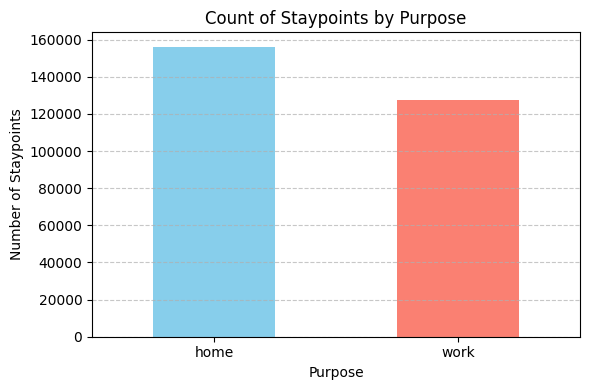

In [40]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(6, 4))
purpose_counts.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Count of Staypoints by Purpose")
plt.xlabel("Purpose")
plt.ylabel("Number of Staypoints")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

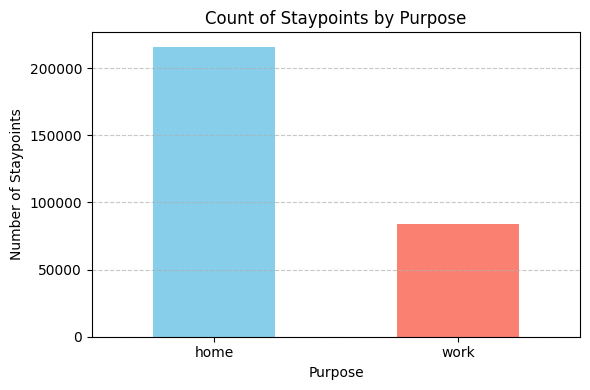

In [51]:
import matplotlib.pyplot as plt

# Plot
plt.figure(figsize=(6, 4))
purpose_counts_freq.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Count of Staypoints by Purpose")
plt.xlabel("Purpose")
plt.ylabel("Number of Staypoints")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<Axes: xlabel='purpose'>

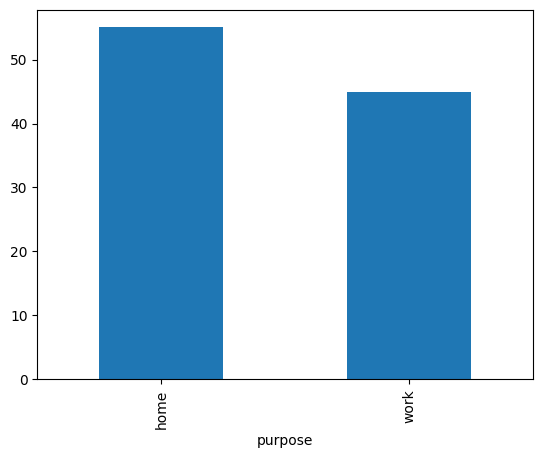

In [41]:
purpose_counts_pct = sp_filtered['purpose'].value_counts(normalize=True) * 100
purpose_counts_pct.plot(kind='bar')

### 13. Visualise work/home locations on map

In [20]:
location_counts = sp_filtered.groupby(
    ['center', 'purpose']
)['user_id'].nunique().reset_index(name='user_count')

max_users = location_counts['user_count'].max()
min_users = location_counts['user_count'].min()

# Step 3: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(location_counts, geometry='center', crs='EPSG:4326')
gdf = gdf.rename(columns={'center': 'geometry'})
# Step 4: Create folium map
m = folium.Map(location=[38.72, -9.14], zoom_start=12)

# Step 5: Add points to map
for _, row in gdf.iterrows():
    color = 'red' if row['purpose'] == 'home' else 'blue'
    
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=1 + (row['user_count'] - min_users) * (20 - 1) / (max_users - min_users),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"{row['purpose'].capitalize()}<br>{row['user_count']} user(s)"
    ).add_to(m)

NameError: name 'sp_filtered' is not defined

In [ ]:
m.save("home_work_osna_method.html")

In [ ]:
location_counts = sp_filtered_freq.groupby(
    ['center', 'purpose']
)['user_id'].nunique().reset_index(name='user_count')

max_users = location_counts['user_count'].max()
min_users = location_counts['user_count'].min()

# Step 3: Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(location_counts, geometry='center', crs='EPSG:4326')
gdf = gdf.rename(columns={'center': 'geometry'})
# Step 4: Create folium map
m = folium.Map(location=[38.72, -9.14], zoom_start=12)

# Step 5: Add points to map
for _, row in gdf.iterrows():
    color = 'red' if row['purpose'] == 'home' else 'blue'
    
    folium.CircleMarker(
        location=[row.geometry.y, row.geometry.x],
        radius=1 + (row['user_count'] - min_users) * (20 - 1) / (max_users - min_users),
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.6,
        popup=f"{row['purpose'].capitalize()}<br>{row['user_count']} user(s)"
    ).add_to(m)

In [ ]:
m.save("home_work_freq_method.html")

### 13. Predict transport mode

In [ ]:
tpls_mode  = tpls.predict_transport_mode()

In [ ]:
tpls

,user_id,started_at,finished_at,geom
id,,,,
13,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-02 08:47:14+00:00,2024-02-02 08:47:42+00:00,"LINESTRING (-9.15809 38.71762, -9.16165 38.71669)"
14,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-02 09:11:50+00:00,2024-02-02 09:12:27+00:00,"LINESTRING (-9.16165 38.71669, -9.15809 38.71762)"
19,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-03 12:05:23+00:00,2024-02-03 12:08:59+00:00,"LINESTRING (-9.15809 38.71762, -9.15809 38.717..."
22,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-05 20:06:19+00:00,2024-02-05 20:10:53+00:00,"LINESTRING (-9.16165 38.71669, -9.15809 38.71762)"
24,0+/LDtVfJw1K4FG4V6epG5wzagQK3ZizhMSn7AVxGgo8=_...,2024-02-06 11:26:38+00:00,2024-02-06 11:30:12+00:00,"LINESTRING (-9.16165 38.71669, -9.15809 38.71762)"
...,...,...,...,...
6654796,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,2024-03-04 09:03:19+00:00,2024-03-04 09:07:06+00:00,"LINESTRING (-9.17087 38.82659, -9.15047 38.81258)"
6654801,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,2024-03-07 16:24:01+00:00,2024-03-07 16:37:31+00:00,"LINESTRING (-9.1615 38.84064, -9.17087 38.8265..."
6654802,0zzhmT0pHFOxOZXe1v/btXZSzzlhBjImUQDLyZPoIiAk=_...,2024-03-09 20:09:30+00:00,2024-03-09 20:10:55+00:00,"LINESTRING (-9.08467 38.86365, -9.12025 38.86541)"


In [ ]:
modal_split = ti.analysis.calculate_modal_split(tpls_mode, metric='count', freq='D', per_user=True)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/trackintel/analysis/modal_split.py:69: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  modal_split = pd.pivot_table(tpls, index=group, columns=["mode"], aggfunc={metric: agg}, fill_value=0)


In [ ]:
modal_split.to_pickle("modal_split_per_user.pkl")

In [ ]:
modal_split_per_day = ti.analysis.calculate_modal_split(tpls_mode, metric='count', freq='D', per_user=False)

/anaconda/envs/azureml_py310_sdkv2/lib/python3.10/site-packages/trackintel/analysis/modal_split.py:69: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  modal_split = pd.pivot_table(tpls, index=group, columns=["mode"], aggfunc={metric: agg}, fill_value=0)


In [ ]:
modal_split_per_day.to_pickle("modal_split_per_day.pkl")

(<Figure size 4110.24x2540.27 with 1 Axes>,
 <Axes: xlabel='days', ylabel='Percentage of daily count'>)

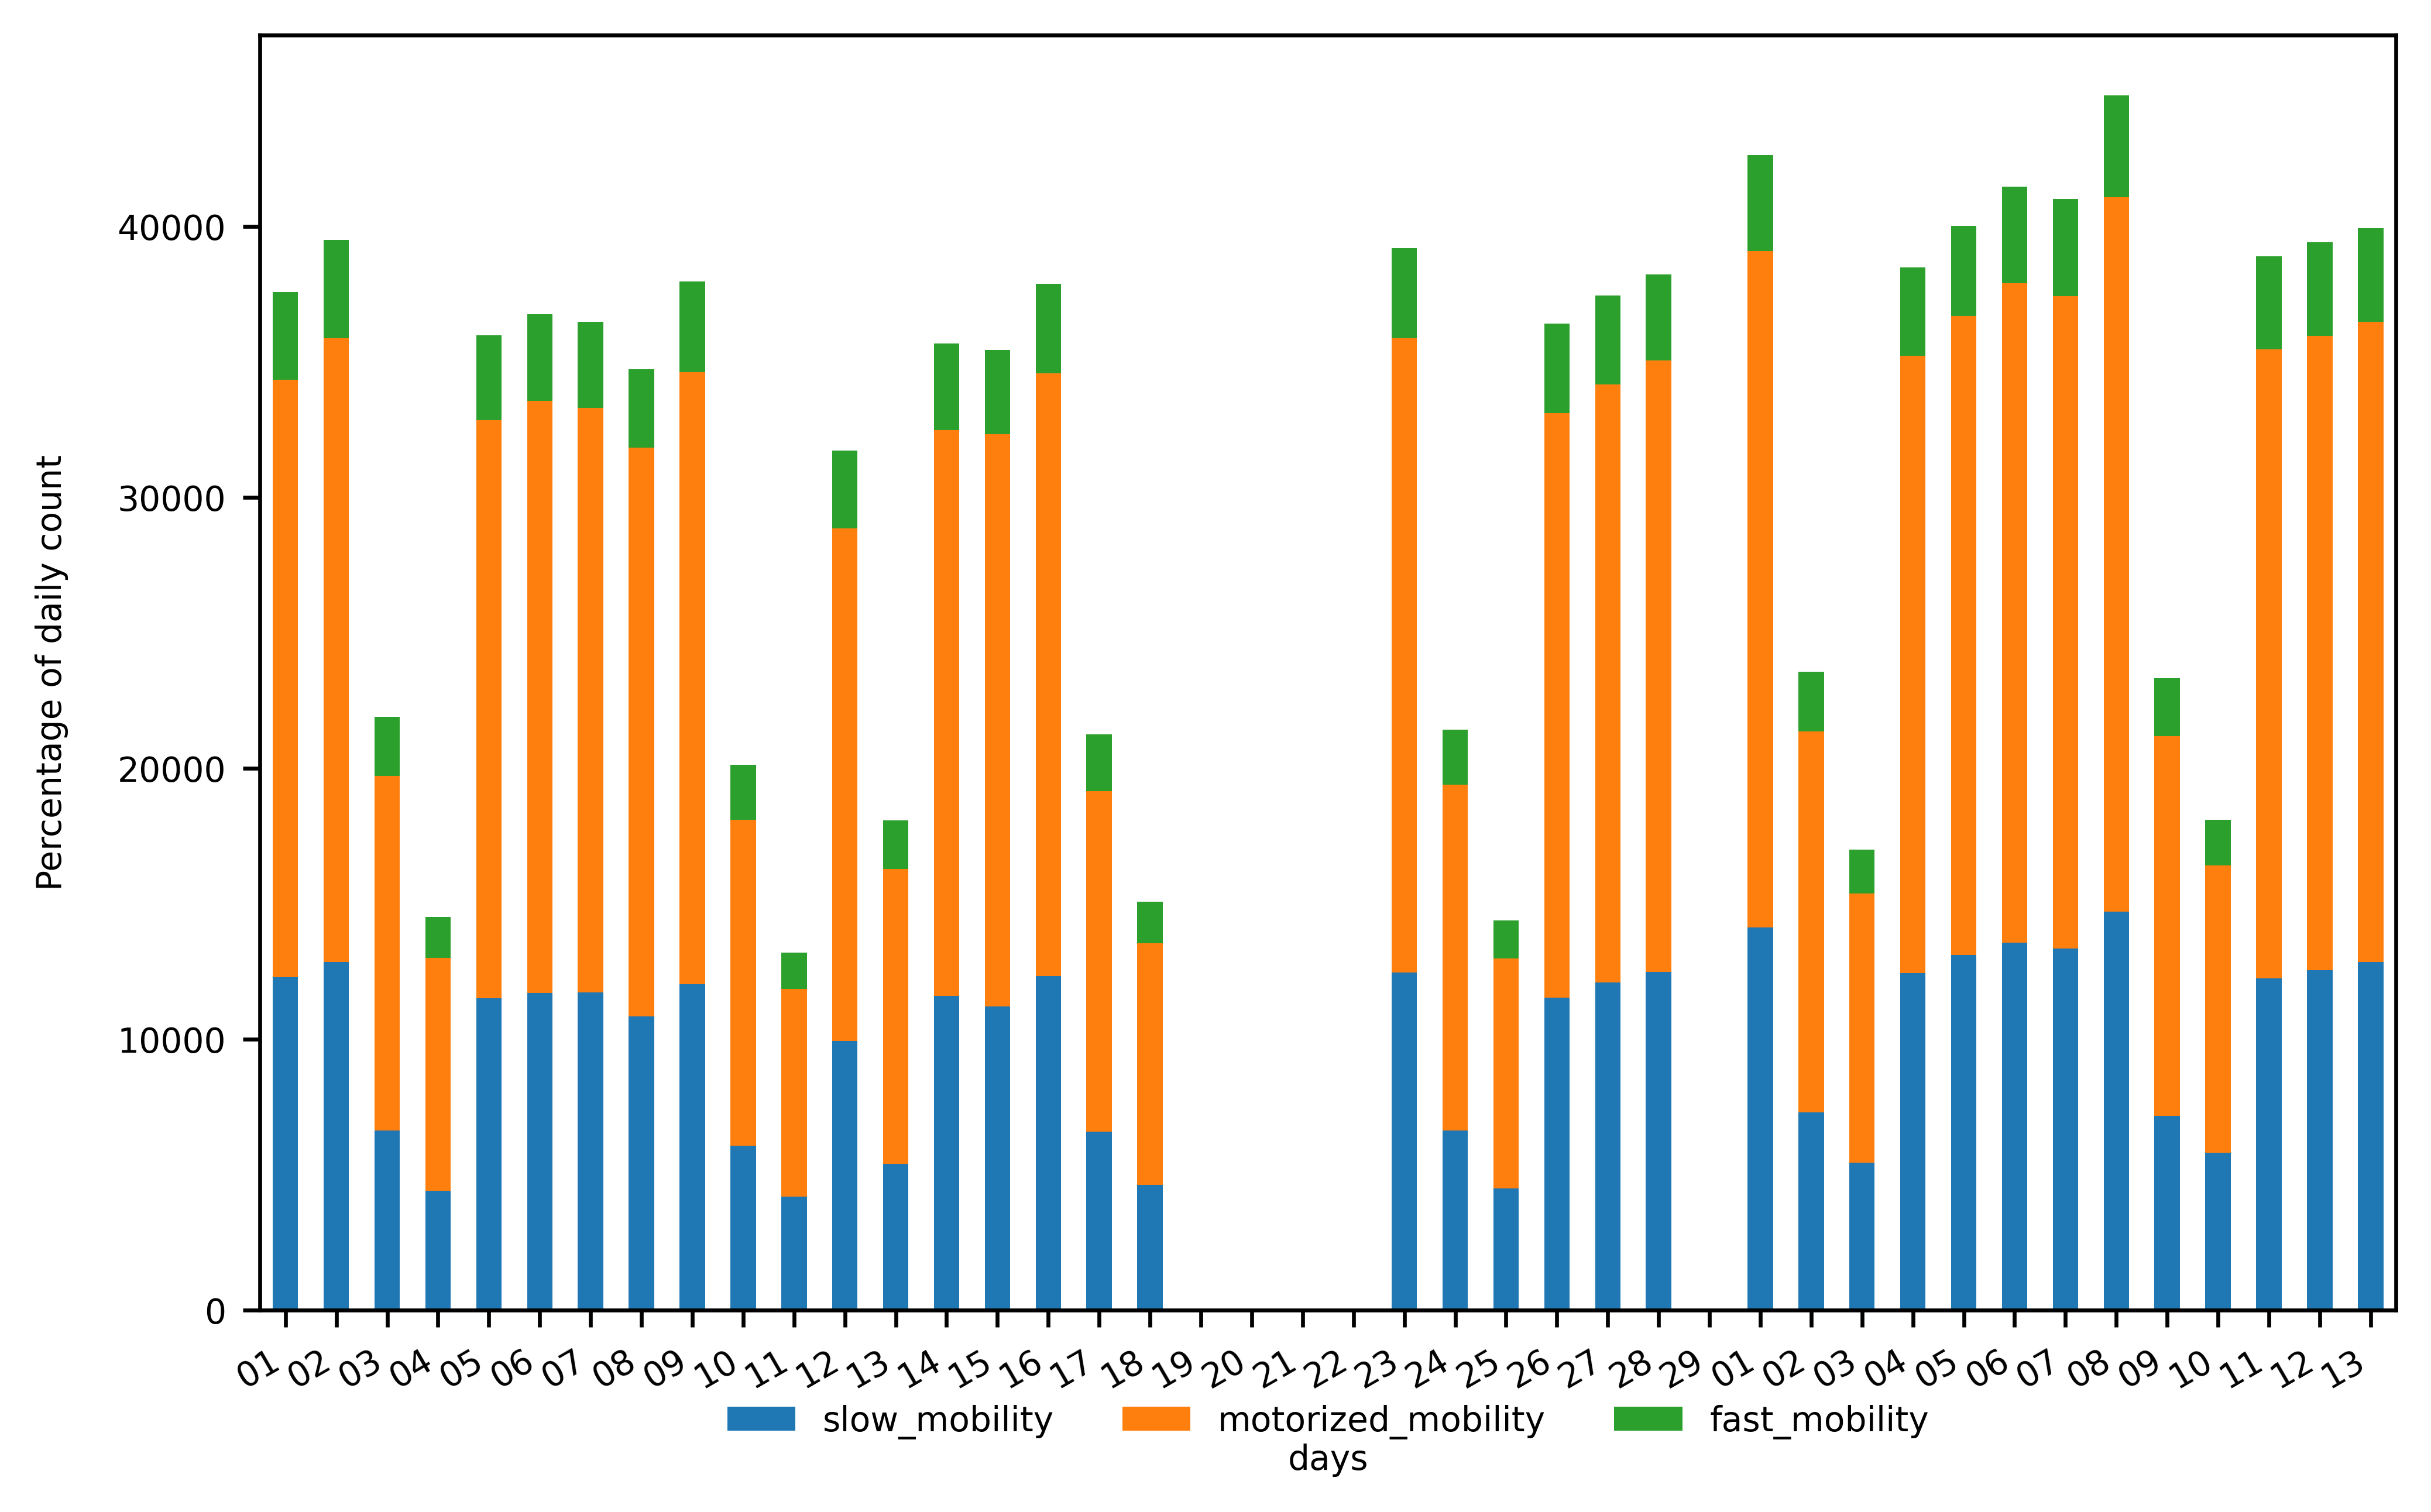

In [ ]:
ti.plot_modal_split(modal_split_per_day, date_fmt_x_axis='%d', y_label='Percentage of daily count', x_label='days')

### 14. Analysis temporal quality

In [ ]:
quality = ti.analysis.temporal_tracking_quality(tpls, granularity="day")

KeyboardInterrupt: 